In [1]:
from pathlib import Path
from textwrap import dedent
import pdb

from tqdm import tqdm
from ipywidgets import interact
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import seaborn as sn

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import transforms as T
from engine import train_one_epoch, evaluate
import utils

In [2]:
DATA_DIR = Path('.') / 'data'
TRN_DIR = DATA_DIR / 'train'

TRN_CSV = DATA_DIR / 'train.csv'

BOX = 'box'
CAT = 'category'
PATH = 'path'
CLASS = 'class'
SUB_ID = 'subject_id'
PRED_BOX = 'predicted_box'
PRED_CLASS = 'predicted_class'
PRED_CAT = 'predicted_category'
IOU = 'IoU'

DEVICE = torch.device('cuda')
torch.backends.cudnn.benchmark = True

CATS = ['background', 'handwritten', 'typewritten']
CLASSES = len(CATS)

In [3]:
trn_df = pd.read_csv(TRN_CSV, index_col='subject_id').reset_index()

trn_df.head()

,subject_id,category,class,box,path,original
0,2995300,typewritten,2,"[231, 446, 368, 564]",data/train/2995300.jpg,data/images/2995300.jpg
1,4128323,typewritten,2,"[156, 322, 250, 382]",data/train/4128323.jpg,data/images/4128323.jpg
2,4128517,handwritten,1,"[155, 321, 248, 382]",data/train/4128517.jpg,data/images/4128517.jpg
3,11783370,handwritten,1,"[552, 1225, 966, 1483]",data/train/11783370.jpg,data/images/11783370.jpg
4,11782469,typewritten,2,"[612, 1182, 977, 1464]",data/train/11782469.jpg,data/images/11782469.jpg


In [4]:
class LabelBabelDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms):
        df[BOX] = df[BOX].apply(json.loads)
        self.df = df
        self.transforms = transforms

    def __getitem__(self, idx):
        subject = self.df.iloc[idx]

        image = Image.open(subject[PATH]).convert('RGB')

        klass = int(subject[CLASS])
        labels = torch.full((1,), klass, dtype=torch.int64)

        boxes = [subject[BOX]]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([subject[SUB_ID]])

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self):
        return self.df.shape[0]

In [5]:
def get_transform(train):
    transforms = [T.ToTensor()]
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomVerticalFlip(0.5))
        transforms.append(T.RandomRotate())
        transforms.append(T.ColorJitter(
            brightness=0.25, contrast=0.25, saturation=0.25, hue=0.25))
    return T.Compose(transforms)

In [6]:
trn_dataset = LabelBabelDataset(trn_df, get_transform(train=True))

In [7]:
def draw_rectangle(ax, bbox, color):
    wide = abs(bbox[2] - bbox[0])
    high = abs(bbox[3] - bbox[1])
    rect = patches.Rectangle(
        bbox[:2],
        wide, high,
        fill=False,
        edgecolor=color,
        lw=2)
    patch = ax.add_patch(rect)

In [8]:
def draw_text(ax, position, text, fontsize=12):
    ax.text(
        *position,
        text,
        verticalalignment='top',
        color='black',
        fontsize=fontsize,
        fontfamily='monospace',
        weight='bold',
        bbox=dict(
            boxstyle='round',
            facecolor='white',
            edgecolor='black'))

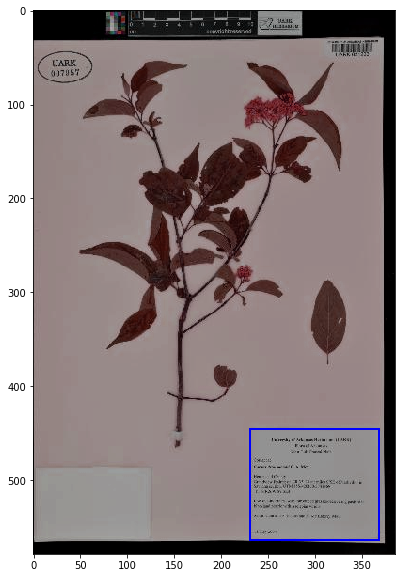

In [13]:
def show_image(idx, figsize):
    image, target = trn_dataset[idx]

    t_box = target['boxes'][0]

    fig, ax = plt.subplots(figsize=(figsize, figsize))

    image = Image.fromarray(image.mul(255).permute(1, 2, 0).byte().numpy())

    ax.imshow(image)

    draw_rectangle(ax, t_box, 'blue')

    plt.show()


# interact(
#     show_image,
#     idx=(0, trn_df.shape[0] - 1),
#     figsize=([10, 12, 15, 20, 25]))
show_image(0, 10)